# TOPIX100 の各銘柄について以下の値を集計し、「寄付きが上向き/下向き」かどうかで銘柄の傾向に違いがあるか確認する
<br>

### 翌日の始値上向き(up)/下向き(down)の陽線(posi)/陰線(nega)の合計値, 平均値, 行数

In [1]:
import os
import numpy as np
import pandas as pd

import glob
from pathlib import Path

from tqdm.auto import tqdm

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語対応
plt.rcParams['font.family'] = 'Yu Gothic'
sns.set(font='Yu Gothic')

#pd.options.plotting.backend = "plotly"

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data_dir = r"C:\Users\81908\jupyter_notebook\stock_work\03.stock_repo\指数乖離投資について\TOPIX100_10年分データ_edit"

In [5]:
stock_ids = [Path(csv).stem for csv in glob.glob(data_dir + "/*csv")]

In [6]:
def get_stock_df(stock_id):
    csv = data_dir + "/" + str(stock_id) + ".csv"
    df = pd.read_csv(
        csv,
        encoding="SHIFT-JIS",
        sep="\t",
        parse_dates=["日付"],
        na_values=["-"],
        dtype="float",
    )
    df["銘柄"] = Path(csv).stem
    
    df = df.sort_values(by=["日付"])
    
    df[f"翌日の始値"] = df["始値"].shift(-1)
    df[f"翌日の終値"] = df["終値"].shift(-1)
    
    # 値の差をそのままつかう場合
    df["翌日の始値-当日の終値"] = df[f"翌日の始値"] - df[f"終値"]
    df["翌日の終値-翌日の始値"] = df[f"翌日の終値"] - df[f"翌日の始値"]
    # 値の差の割合%を取る場合
    #df["翌日の始値-当日の終値"] = ( (df[f"翌日の始値"] - df[f"終値"]) / df[f"終値"] ) * 100 
    #df["翌日の終値-翌日の始値"] = ( (df[f"翌日の終値"] - df[f"翌日の始値"]) / df[f"翌日の始値"] ) * 100 
    
    return df

In [7]:
def up_down_summary(stock_id, start_date="2020-01-01", end_date="2020-12-31"):
    df = get_stock_df(stock_id=stock_id)
    
    df = df[(df["日付"] >= start_date) & (df["日付"] <= end_date)]
    df = df[df["翌日の終値-翌日の始値"].notnull()]  # 欠損ではない行のみ
    
    # 翌日の 陽線/陰線 の合計
    all_count = df.shape[0]
    all_sum = sum(df["翌日の終値-翌日の始値"])
    
    # 翌日の始値上向き + 翌日陽線のみ
    df_up_posi = df[
        (df["翌日の始値-当日の終値"] > 0.0) &
        (df["翌日の終値-翌日の始値"] > 0.0)
    ]
    up_posi_count = df_up_posi.shape[0]
    up_posi_sum = sum(df_up_posi["翌日の終値-翌日の始値"])
    
    # 翌日の始値上向き + 翌日陰線のみ
    df_up_nega = df[
        (df["翌日の始値-当日の終値"] > 0.0) &
        (df["翌日の終値-翌日の始値"] < 0.0)
    ]
    up_nega_count = df_up_nega.shape[0]
    up_nega_sum = sum(df_up_nega["翌日の終値-翌日の始値"])

    # 翌日の始値下向き + 翌日陽線のみ
    df_down_posi = df[
        (df["翌日の始値-当日の終値"] < 0.0) &
        (df["翌日の終値-翌日の始値"] > 0.0)
    ]
    down_posi_count = df_down_posi.shape[0]
    down_posi_sum = sum(df_down_posi["翌日の終値-翌日の始値"])

    # 翌日の始値下向き + 翌日陰線のみ
    df_down_nega = df[
        (df["翌日の始値-当日の終値"] < 0.0) &
        (df["翌日の終値-翌日の始値"] < 0.0)
    ]
    down_nega_count = df_down_nega.shape[0]
    down_nega_sum = sum(df_down_nega["翌日の終値-翌日の始値"])

    # 翌日の始値上向きの 陽線/陰線 の合計
    up_sum = up_posi_sum + up_nega_sum

    # 翌日の始値下向きの 陽線/陰線 の合計
    down_sum = down_posi_sum + down_nega_sum
    
    
    dict_summary = dict()
    dict_summary["stock_id"] = stock_id
    dict_summary["開始日"] = start_date
    dict_summary["終了日"] = end_date
    
    dict_summary["開始日の始値"] = int(df.iloc[0]["始値"])
    dict_summary["終了日の始値"] = int(df.iloc[-1]["始値"])
    dict_summary["始値の平均"] = int(df["始値"].mean())
    
    dict_summary["取引日数"] = all_count  # 行数
    dict_summary["翌日の陽線/陰線の合計"] = all_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["翌日の陽線/陰線の平均"] = round(all_sum / all_count, 3)  # 翌日の 陽線/陰線 の平均
    
    # 翌日の始値上向き + 翌日陽線のみ
    dict_summary["up_posi_count"] = up_posi_count  # 行数
    dict_summary["up_posi_sum"] = up_posi_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["up_posi_mean"] = round(up_posi_sum / up_posi_count, 3) # 翌日の 陽線/陰線 の平均
    
    # 翌日の始値上向き + 翌日陰線のみ
    dict_summary["up_nega_count"] = up_nega_count  # 行数
    dict_summary["up_nega_sum"] = up_nega_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["up_nega_mean"] = round(up_nega_sum / up_nega_count, 3)  # 翌日の 陽線/陰線 の平均
    
    # 翌日の始値下向き + 翌日陽線のみ
    dict_summary["down_posi_count"] = down_posi_count  # 行数
    dict_summary["down_posi_sum"] = down_posi_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["down_posi_mean"] = round(down_posi_sum / down_posi_count, 3)  # 翌日の 陽線/陰線 の平均
    
     # 翌日の始値下向き + 翌日陰線のみ 
    dict_summary["down_nega_count"] = down_nega_count  # 行数
    dict_summary["down_nega_sum"] = down_nega_sum  # 翌日の 陽線/陰線 の合計
    dict_summary["down_nega_mean"] = round(down_nega_sum / down_nega_count, 3)  # 翌日の 陽線/陰線 の平均
    
    dict_summary["翌日の始値上向き_sum"] = up_sum  # 翌日の始値上向きの 陽線/陰線 の合計
    dict_summary["翌日の始値上向き_mean"] = round(up_sum / (up_posi_count + up_nega_count), 3)  # 翌日の始値上向きの 陽線/陰線 の平均
    
    dict_summary["翌日の始値下向き_sum"] = down_sum  # 翌日の始値下向きの 陽線/陰線 の合計
    dict_summary["翌日の始値下向き_mean"] = round(down_sum / (down_posi_count + down_nega_count), 3)  # 翌日の始値下向きの 陽線/陰線 の平均
    
    dict_summary["翌日陽線の割合"] = round((up_posi_count + down_posi_count) / all_count * 100, 1)  # 翌日陽線の割合
    dict_summary["翌日陰線の割合"] = round((up_nega_count + down_nega_count) / all_count * 100, 1)  # 翌日陰線の割合

    dict_summary["翌日の始値上向きの割合"] = round((up_posi_count + up_nega_count) / all_count * 100, 1)
    dict_summary["翌日の始値下向きの割合"] = round((down_posi_count + down_nega_count) / all_count * 100, 1)
    
    dict_summary["翌日の始値上向きかつ陽線の割合"] = round(up_posi_count / all_count * 100, 1) 
    dict_summary["翌日の始値上向きかつ陰線の割合"] = round(up_nega_count / all_count * 100, 1) 
    dict_summary["翌日の始値下向きかつ陰線の割合"] = round(down_nega_count / all_count * 100, 1)
    dict_summary["翌日の始値下向きかつ陽線の割合"] = round(down_posi_count / all_count * 100, 1)
    
    return dict_summary

In [8]:
# debug
df = get_stock_df(stock_id=1925)
display(df)
dict_summary = up_down_summary(stock_id=1925, start_date="2020-01-01", end_date="2020-12-31")
display(dict_summary)

,日付,始値,高値,安値,終値,前日比,出来高,売買代金,貸株残高,融資残高,貸借倍率,5DMA,25DMA,75DMA,100DMA,200DMA,銘柄,翌日の始値,翌日の終値,翌日の始値-当日の終値,翌日の終値-翌日の始値
2447,2011-02-14,1050.0,1051.0,1034.0,1043.0,0.0,1498000.0,1559878.0,1639000.0,70000.0,0.04,NaN,NaN,NaN,NaN,NaN,1925,1048.0,1042.0,5.0,-6.0
2446,2011-02-15,1048.0,1050.0,1036.0,1042.0,-1.0,1443000.0,1503978.0,1635000.0,74000.0,0.05,NaN,NaN,NaN,NaN,NaN,1925,1050.0,1041.0,8.0,-9.0
2445,2011-02-16,1050.0,1053.0,1036.0,1041.0,-1.0,1938000.0,2023659.0,1626000.0,120000.0,0.07,NaN,NaN,NaN,NaN,NaN,1925,1043.0,1037.0,2.0,-6.0
2444,2011-02-17,1043.0,1044.0,1032.0,1037.0,-4.0,1688000.0,1752178.0,1532000.0,153000.0,0.10,NaN,NaN,NaN,NaN,NaN,1925,1042.0,1041.0,5.0,-1.0
2443,2011-02-18,1042.0,1045.0,1032.0,1041.0,4.0,1998000.0,2075870.0,1382000.0,142000.0,0.10,1040.8,NaN,NaN,NaN,NaN,1925,1040.0,1048.0,-1.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-02-05,3130.0,3210.0,3115.0,3199.0,106.0,2222900.0,7057909.0,30400.0,20800.0,0.68,3066.4,3053.82,3082.09,3027.77,2838.83,1925,3196.0,3217.0,-3.0,21.0
3,2021-02-08,3196.0,3273.0,3194.0,3217.0,18.0,2061900.0,6655672.0,21500.0,20400.0,0.95,3112.4,3059.94,3086.65,3030.53,2841.25,1925,3243.0,3215.0,26.0,-28.0
2,2021-02-09,3243.0,3255.0,3165.0,3215.0,-2.0,1930300.0,6214290.0,22300.0,8300.0,0.37,3158.0,3066.86,3091.65,3033.19,2843.71,1925,3235.0,3303.0,20.0,68.0
1,2021-02-10,3235.0,3306.0,3200.0,3303.0,88.0,2023800.0,6643430.0,45000.0,11600.0,0.26,3205.4,3079.00,3096.79,3036.12,2846.83,1925,3303.0,3269.0,0.0,-34.0


{'stock_id': 1925,
 '開始日': '2020-01-01',
 '終了日': '2020-12-31',
 '開始日の始値': 3356,
 '終了日の始値': 3112,
 '始値の平均': 2886,
 '取引日数': 242,
 '翌日の陽線/陰線の合計': -650.5,
 '翌日の陽線/陰線の平均': -2.688,
 'up_posi_count': 64,
 'up_posi_sum': 2405.0,
 'up_posi_mean': 37.578,
 'up_nega_count': 53,
 'up_nega_sum': -1941.5,
 'up_nega_mean': -36.632,
 'down_posi_count': 53,
 'down_posi_sum': 1351.5,
 'down_posi_mean': 25.5,
 'down_nega_count': 64,
 'down_nega_sum': -2554.0,
 'down_nega_mean': -39.906,
 '翌日の始値上向き_sum': 463.5,
 '翌日の始値上向き_mean': 3.962,
 '翌日の始値下向き_sum': -1202.5,
 '翌日の始値下向き_mean': -10.278,
 '翌日陽線の割合': 48.3,
 '翌日陰線の割合': 48.3,
 '翌日の始値上向きの割合': 48.3,
 '翌日の始値下向きの割合': 48.3,
 '翌日の始値上向きかつ陽線の割合': 26.4,
 '翌日の始値上向きかつ陰線の割合': 21.9,
 '翌日の始値下向きかつ陰線の割合': 26.4,
 '翌日の始値下向きかつ陽線の割合': 21.9}

In [9]:
df_summary = None
for stock_id in tqdm(stock_ids):
    dict_summary = up_down_summary(stock_id=stock_id, start_date="2020-01-01", end_date="2020-12-31")
    if df_summary is None:
        df_summary = pd.DataFrame.from_dict(dict_summary, orient='index').T
    else:
        df_summary = df_summary.append(dict_summary, ignore_index=True)

df_summary.head(5)

,stock_id,開始日,終了日,開始日の始値,終了日の始値,始値の平均,取引日数,翌日の陽線/陰線の合計,翌日の陽線/陰線の平均,up_posi_count,up_posi_sum,up_posi_mean,up_nega_count,up_nega_sum,up_nega_mean,down_posi_count,down_posi_sum,down_posi_mean,down_nega_count,down_nega_sum,down_nega_mean,翌日の始値上向き_sum,翌日の始値上向き_mean,翌日の始値下向き_sum,翌日の始値下向き_mean,翌日陽線の割合,翌日陰線の割合,翌日の始値上向きの割合,翌日の始値下向きの割合,翌日の始値上向きかつ陽線の割合,翌日の始値上向きかつ陰線の割合,翌日の始値下向きかつ陰線の割合,翌日の始値下向きかつ陽線の割合
0,1925,2020-01-01,2020-12-31,3356,3112,2886,242,-650.5,-2.688,64,2405,37.578,53,-1941.5,-36.632,53,1351.5,25.5,64,-2554,-39.906,463.5,3.962,-1202.5,-10.278,48.3,48.3,48.3,48.3,26.4,21.9,26.4,21.9
1,1928,2020-01-01,2020-12-31,2309,2125,2012,242,-484.5,-2.002,55,1108,20.145,58,-1285.5,-22.164,62,1267,20.435,62,-1542,-24.871,-177.5,-1.571,-275,-2.218,48.3,49.6,46.7,51.2,22.7,24,25.6,25.6
2,2413,2020-01-01,2020-12-31,3260,9818,5267,242,5336,22.05,69,7373,106.855,52,-3910,-75.192,60,6401,106.683,48,-4123,-85.896,3463,28.62,2278,21.093,53.3,41.3,50,44.6,28.5,21.5,19.8,24.8
3,2502,2020-01-01,2020-12-31,4928,4300,3972,242,-868,-3.587,56,3152,56.286,62,-2731,-44.048,48,2282,47.542,67,-3630,-54.179,421,3.568,-1348,-11.722,43,53.3,48.8,47.5,23.1,25.6,27.7,19.8
4,2503,2020-01-01,2020-12-31,2356,2456,2174,242,388,1.603,64,1568.5,24.508,43,-922.5,-21.453,51,1316,25.804,67,-1746,-26.06,646,6.037,-430,-3.644,47.5,45.5,44.2,48.8,26.4,17.8,27.7,21.1


In [10]:
# 見にくいので 行数の列 は削除
df_summary = df_summary[["stock_id", "開始日", "終了日", 
                         "取引日数",
                         "開始日の始値", "終了日の始値", "始値の平均",
                         "翌日の陽線/陰線の合計", 
                         "翌日の陽線/陰線の平均",
                         #"up_posi_sum", "up_nega_sum", "down_posi_sum", "down_nega_sum", 
                         "翌日の始値上向き_sum", "翌日の始値下向き_sum", 
                         #"up_posi_mean", "up_nega_mean", "down_posi_mean", "down_nega_mean", 
                         "翌日の始値上向き_mean", "翌日の始値下向き_mean", 
                         #"翌日陽線の割合", "翌日陰線の割合",
                         #"翌日の始値上向きの割合", "翌日の始値下向きの割合",
                         "翌日の始値上向きかつ陽線の割合", "翌日の始値上向きかつ陰線の割合", "翌日の始値下向きかつ陰線の割合", "翌日の始値下向きかつ陽線の割合",
                        ]]

In [11]:
# 銘柄名つける
stock_name = pd.read_csv("../stock_name_TOPIX100.csv", encoding="SHIFT-JIS", dtype="str")
df_summary = pd.merge(stock_name, df_summary, on="stock_id")

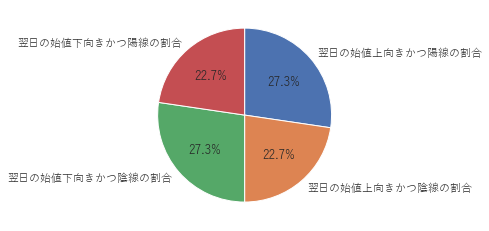

In [12]:
x = df_summary.iloc[0]
u_p = x["翌日の始値上向きかつ陽線の割合"]
u_n = x["翌日の始値上向きかつ陰線の割合"]
d_n = x["翌日の始値下向きかつ陰線の割合"]
d_p = x["翌日の始値下向きかつ陽線の割合"]
plt.pie([u_p, u_n, d_n, d_p], 
        labels=["翌日の始値上向きかつ陽線の割合", "翌日の始値上向きかつ陰線の割合", "翌日の始値下向きかつ陰線の割合", "翌日の始値下向きかつ陽線の割合"], 
        counterclock=False, 
        startangle=90, 
        autopct="%1.1f%%")
plt.show()

,0
翌日の始値上向きかつ陰線の割合,21.9
翌日の始値下向きかつ陽線の割合,21.9
翌日の始値上向きかつ陽線の割合,26.4
翌日の始値下向きかつ陰線の割合,26.4


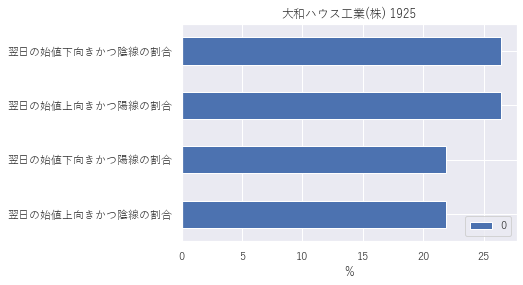

In [13]:
#plt.barh(["翌日の始値上向きかつ陽線の割合", "翌日の始値上向きかつ陰線の割合", "翌日の始値下向きかつ陰線の割合", "翌日の始値下向きかつ陽線の割合"], 
#         [u_p, u_n, d_n, d_p], 
#         align='center')

_df = pd.DataFrame({"翌日の始値上向きかつ陽線の割合": [u_p], 
                    "翌日の始値上向きかつ陰線の割合": [u_n], 
                    "翌日の始値下向きかつ陰線の割合": [d_n], 
                    "翌日の始値下向きかつ陽線の割合": [d_p]})
_df = _df.T.sort_values(by=0)
display(_df)
_df.plot.barh(legend=False)
#_df.plot.barh()

plt.title(f'{x["name"]} {x["stock_id"]}')
plt.xlabel('%')
plt.show()

In [14]:
def plot_sort_type_up_down(_df, sort_type, ascending=True):
    _df = _df.head(10)[[f"name", f"翌日の始値上向き_{sort_type}", f"翌日の始値下向き_{sort_type}"]].set_index('name')
    _df = _df.sort_values(by=f"翌日の始値上向き_{sort_type}", ascending=ascending)
    
    _df.plot.barh(figsize=(8, 10))
    plt.xlabel(f'円（期間中の陽線陰線の{sort_type}）')
    plt.show()

### df_summary の各列の意味
- start_date: 開始日
- end_date: 終了日
- all_sum: 期間内での全陽線/陰線の合計値
- all_mean: 期間内での全陽線/陰線の平均値。値が1以下の場合は単位%
- up_sum: 期間内での翌日の寄付き上向きの陽線/陰線の合計値
- up_mean: 期間内での翌日の寄付き上向きの陽線/陰線の平均値。値が1以下の場合は単位%
- down_sum: 期間内での翌日の寄付き下向きの陽線/陰線の合計値
- down_mean: 期間内での翌日の寄付き下向きの陽線/陰線の平均値。値が1以下の場合は単位%
- posi_count_percent: 期間内での翌日陽線の割合(%)
- nega_count_percent: 期間内での翌日陰線の割合(%)

In [15]:
sort_type = "sum"
#sort_type = "mean"
price_limit = 5000.0

In [16]:
# 翌日の始値上向きの 陽線/陰線 の合計値大きいのだけ
_df = df_summary.sort_values(by=f"翌日の始値上向き_{sort_type}", ascending=False).head(15)
display(_df)

,name,stock_id,開始日,終了日,取引日数,開始日の始値,終了日の始値,始値の平均,翌日の陽線/陰線の合計,翌日の陽線/陰線の平均,翌日の始値上向き_sum,翌日の始値下向き_sum,翌日の始値上向き_mean,翌日の始値下向き_mean,翌日の始値上向きかつ陽線の割合,翌日の始値上向きかつ陰線の割合,翌日の始値下向きかつ陰線の割合,翌日の始値下向きかつ陽線の割合
84,(株)ファーストリテイリング,9983,2020-01-01,2020-12-31,242,63790,91450,63096,1230,5.083,19420,-16460,150.543,-156.762,30.6,22.7,23.1,20.2
2,エムスリー(株),2413,2020-01-01,2020-12-31,242,3260,9818,5267,5336,22.05,3463,2278,28.62,21.093,28.5,21.5,19.8,24.8
54,東京エレクトロン(株),8035,2020-01-01,2020-12-31,242,23605,38500,26627,4555,18.822,2940,1915,22.105,18.413,25.2,29.8,19.4,23.6
33,ダイキン工業(株),6367,2020-01-01,2020-12-31,242,15190,23495,17689,2510,10.372,1985,605,14.704,6.173,29.8,26,19.8,20.7
50,(株)バンダイナムコＨＤ,7832,2020-01-01,2020-12-31,242,6482,8935,6683,2960,12.231,1733,1727,15.613,14.392,22.7,23.1,19.4,30.2
16,中外製薬(株),4519,2020-01-01,2020-12-31,242,3333,5505,4579,772.3,3.191,1134.6,-339.3,9.534,-3.201,29.8,19.4,23.6,20.2
38,ソニーグループ(株),6758,2020-01-01,2020-12-31,242,7331,10355,7871,1044,4.314,1101,197,8.278,1.913,26.9,28.1,22.3,20.2
19,第一三共(株),4568,2020-01-01,2020-12-31,242,2384,3547,2867,817.8,3.379,1092.2,-378,9.256,-3.231,26,22.7,25.6,22.7
74,西日本旅客鉄道(株),9021,2020-01-01,2020-12-31,242,9380,5453,6347,-1867,-7.715,1088,-2835,10.667,-21.316,19,23.1,34.3,20.7
44,トヨタ自動車(株),7203,2020-01-01,2020-12-31,242,7599,7943,7029,1119,4.624,1059,-46,9.209,-0.383,24,23.6,27.3,22.3


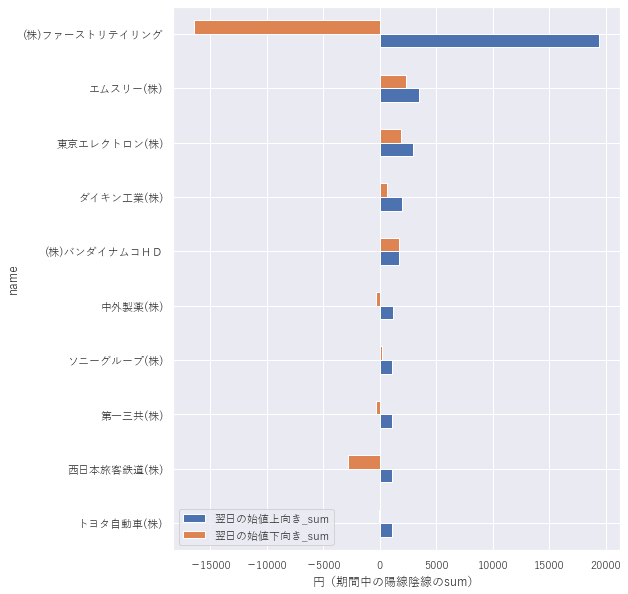

In [17]:
plot_sort_type_up_down(_df, sort_type)

In [18]:
# 翌日の始値上向きの 陽線/陰線 > 0.0 かつ 翌日の始値下向きの 陽線/陰線 < 0.0 のだけ
_df = df_summary[
    (df_summary[f"翌日の始値上向き_{sort_type}"] > 0.0) &
    (df_summary[f"翌日の始値下向き_{sort_type}"] < 0.0) &
    (df_summary[f"始値の平均"] < price_limit)  # 株価の高すぎる銘柄は除く
].sort_values(by=f"翌日の始値上向き_{sort_type}", ascending=False).head(15)
display(_df)

,name,stock_id,開始日,終了日,取引日数,開始日の始値,終了日の始値,始値の平均,翌日の陽線/陰線の合計,翌日の陽線/陰線の平均,翌日の始値上向き_sum,翌日の始値下向き_sum,翌日の始値上向き_mean,翌日の始値下向き_mean,翌日の始値上向きかつ陽線の割合,翌日の始値上向きかつ陰線の割合,翌日の始値下向きかつ陰線の割合,翌日の始値下向きかつ陽線の割合
16,中外製薬(株),4519,2020-01-01,2020-12-31,242,3333,5505,4579,772.3,3.191,1134.6,-339.3,9.534,-3.201,29.8,19.4,23.6,20.2
19,第一三共(株),4568,2020-01-01,2020-12-31,242,2384,3547,2867,817.8,3.379,1092.2,-378,9.256,-3.231,26,22.7,25.6,22.7
45,本田技研工業(株),7267,2020-01-01,2020-12-31,242,3067,2901,2727,643.5,2.659,1043,-415,10.225,-3.242,21.5,20.7,28.9,24
72,住友不動産(株),8830,2020-01-01,2020-12-31,242,3827,3212,3154,-304,-1.256,936.5,-1092.5,8.592,-8.602,26.4,18.6,26.9,25.6
39,(株)デンソー,6902,2020-01-01,2020-12-31,242,4903,6190,4428,336,1.388,659,-249,5.446,-2.223,24.4,25.6,24.4,21.9
47,(株)ＳＵＢＡＲＵ,7270,2020-01-01,2020-12-31,242,2700,2064,2266,-23.5,-0.097,646,-630,6.212,-4.961,23.1,19.8,32.6,19.8
4,キリンＨＤ(株),2503,2020-01-01,2020-12-31,242,2356,2456,2174,388,1.603,646,-430,6.037,-3.644,26.4,17.8,27.7,21.1
70,三井不動産(株),8801,2020-01-01,2020-12-31,242,2673,2161,2104,66.5,0.275,629,-705,5.879,-5.64,26.4,17.8,30.2,21.5
0,大和ハウス工業(株),1925,2020-01-01,2020-12-31,242,3356,3112,2886,-650.5,-2.688,463.5,-1202.5,3.962,-10.278,26.4,21.9,26.4,21.9
3,アサヒグループＨＤ(株),2502,2020-01-01,2020-12-31,242,4928,4300,3972,-868,-3.587,421,-1348,3.568,-11.722,23.1,25.6,27.7,19.8


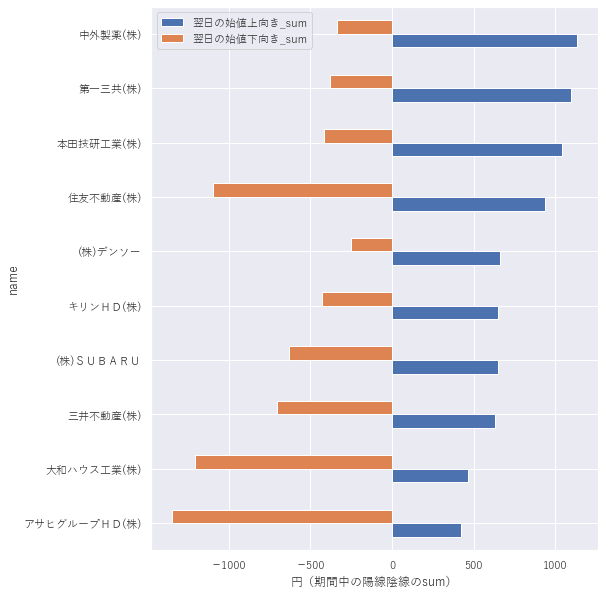

In [19]:
plot_sort_type_up_down(_df, sort_type)

In [20]:
# 翌日で買いでデイトレしとけばほぼ勝てた銘柄
_df = df_summary[
    (df_summary[f"翌日の始値上向き_{sort_type}"] > 0.0) &
    (df_summary[f"翌日の始値下向き_{sort_type}"] > 0.0) &
    (df_summary[f"始値の平均"] < price_limit)  # 株価の高すぎる銘柄は除く
].sort_values(by=f"翌日の始値上向き_{sort_type}", ascending=False)
display(_df)

,name,stock_id,開始日,終了日,取引日数,開始日の始値,終了日の始値,始値の平均,翌日の陽線/陰線の合計,翌日の陽線/陰線の平均,翌日の始値上向き_sum,翌日の始値下向き_sum,翌日の始値上向き_mean,翌日の始値下向き_mean,翌日の始値上向きかつ陽線の割合,翌日の始値上向きかつ陰線の割合,翌日の始値下向きかつ陰線の割合,翌日の始値下向きかつ陽線の割合
57,イオン(株),8267,2020-01-01,2020-12-31,242,2230,3394,2525,1070,4.421,817.5,266.5,6.54,2.491,30.6,21.1,21.5,22.7
27,住友金属鉱山(株),5713,2020-01-01,2020-12-31,242,3451,4561,3195,860,3.554,281.5,455.5,2.386,3.86,27.3,21.5,23.1,25.6
77,日本電信電話(株),9432,2020-01-01,2020-12-31,242,2757,2662,2513,819.5,3.386,278,740.5,2.598,6.12,21.1,23.1,21.1,28.9
66,(株)日本取引所グループ,8697,2020-01-01,2020-12-31,242,1872,2691,2361,569,2.351,95.5,430,0.776,3.909,26.9,24,20.7,24.8
78,ＫＤＤＩ(株),9433,2020-01-01,2020-12-31,242,3237,3110,3114,206,0.851,76,178.5,0.661,1.684,22.3,25.2,19,24.8
53,三井物産(株),8031,2020-01-01,2020-12-31,242,1945,1905,1744,192.5,0.795,31.5,119,0.3,0.952,21.1,22.3,23.6,28.1
37,パナソニック(株),6752,2020-01-01,2020-12-31,242,1014,1194,975,54.7,0.226,28.7,80.6,0.247,0.683,25.2,22.7,25.2,23.6
30,日本郵政(株),6178,2020-01-01,2020-12-31,242,1016,804,820,0.4,0.002,14.1,9,0.131,0.071,20.7,24,29.3,22.7


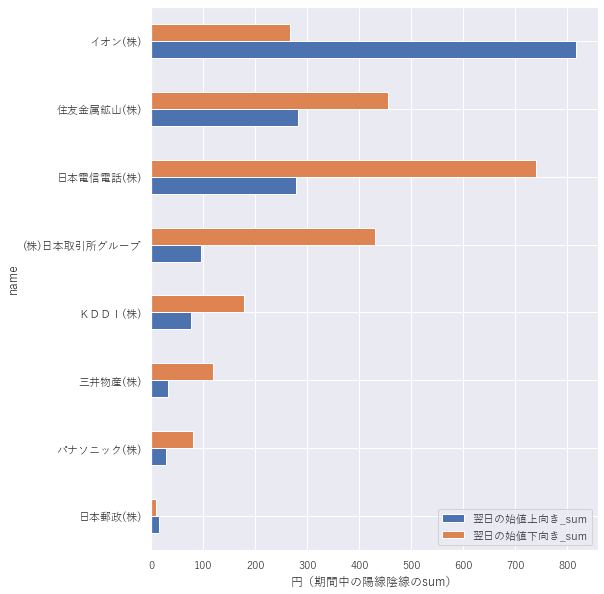

In [21]:
plot_sort_type_up_down(_df, sort_type)

In [22]:
# 翌日売りでデイトレしとけばほぼ勝てた銘柄
_df = df_summary[
    (df_summary[f"翌日の始値上向き_{sort_type}"] < 0.0) &
    (df_summary[f"翌日の始値下向き_{sort_type}"] < 0.0) &
    (df_summary[f"始値の平均"] < price_limit)  # 株価の高すぎる銘柄は除く
].sort_values(by=f"翌日の始値下向き_{sort_type}", ascending=True)
display(_df)

,name,stock_id,開始日,終了日,取引日数,開始日の始値,終了日の始値,始値の平均,翌日の陽線/陰線の合計,翌日の陽線/陰線の平均,翌日の始値上向き_sum,翌日の始値下向き_sum,翌日の始値上向き_mean,翌日の始値下向き_mean,翌日の始値上向きかつ陽線の割合,翌日の始値上向きかつ陰線の割合,翌日の始値下向きかつ陰線の割合,翌日の始値下向きかつ陽線の割合
7,(株)セブン＆アイ・ＨＤ,3382,2020-01-01,2020-12-31,242,3950,3711,3596,-830,-3.43,-93,-926,-0.775,-8.195,26,23.6,29.3,17.4
13,武田薬品工業(株),4502,2020-01-01,2020-12-31,242,4297,3780,3842,-1137.5,-4.7,-326.5,-740,-2.612,-6.916,24,27.7,24,20.2
42,三菱重工業(株),7011,2020-01-01,2020-12-31,242,4205,3192,2847,-1075,-4.442,-423.5,-706,-3.651,-5.835,20.2,27.7,28.5,21.5
76,ＡＮＡ ＨＤ(株),9202,2020-01-01,2020-12-31,242,3600,2280,2643,-1196.5,-4.944,-359,-598.5,-3.234,-5.115,19,26.9,27.7,20.7
20,大塚ＨＤ(株),4578,2020-01-01,2020-12-31,242,4813,4493,4437,-929,-3.839,-48,-486,-0.381,-4.378,24.4,27.7,24.8,21.1
29,(株)リクルートＨＤ,6098,2020-01-01,2020-12-31,242,4052,4398,3840,-1227,-5.07,-485.5,-393.5,-3.947,-3.712,25.2,25.6,22.7,21.1
46,スズキ(株),7269,2020-01-01,2020-12-31,242,4577,4857,4217,-553.5,-2.287,-317,-298.5,-2.709,-2.573,22.3,26,24.4,23.6
1,積水ハウス(株),1928,2020-01-01,2020-12-31,242,2309,2125,2012,-484.5,-2.002,-177.5,-275,-1.571,-2.218,22.7,24,25.6,25.6
62,(株)みずほＦＧ,8411,2020-01-01,2020-12-31,242,1665,1320,1374,-383,-1.583,-121,-239.5,-1.052,-2.138,20.2,27.3,26.4,19.8
9,旭化成(株),3407,2020-01-01,2020-12-31,242,1204,1051,913,-583.9,-2.413,-302.6,-230,-2.31,-2.212,25.2,28.9,24,19


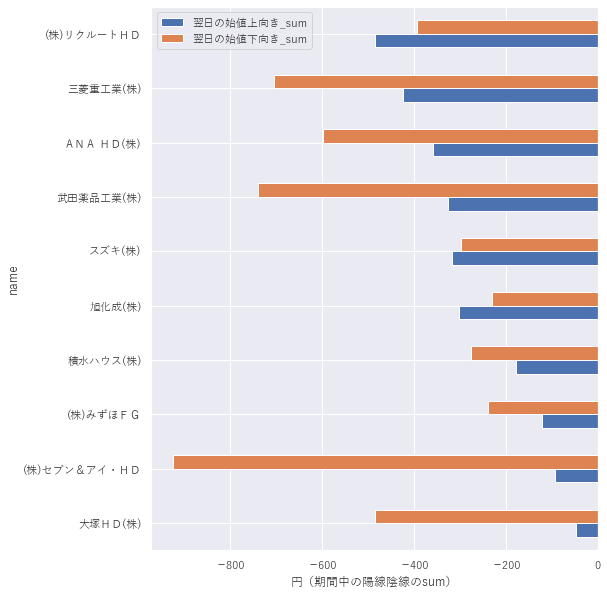

In [23]:
plot_sort_type_up_down(_df, sort_type, ascending=False)